# lineart test

In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
import numpy as np
from flat import rgba, font, shape, strike, document
from IPython.display import Image
import dask

from lineart.shapes import Octahedron
from lineart.transforms import rotate, rotate_xy, sample_line, add_z_jitter

## First experiment

In [17]:
image_size = 100

In [18]:
# colors
canvas = rgba(254, 250, 219,255)
sand = rgba(254, 250, 219,50)
blue = rgba(33, 80, 98,255)
red = rgba(255, 0, 0,255)
# styles
background = shape().fill(blue).nostroke()
netstyle = shape().stroke(canvas).width(1)
sandstyle = shape().fill(sand).nostroke()
debug = shape().stroke(red).width(0.5)

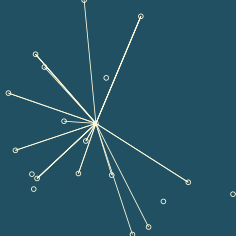

In [19]:
# page setup
d = document(image_size, image_size, 'mm')
page = d.addpage()
page.place(background.rectangle(0,0,image_size,image_size))

nodes = np.random.rand(20,2)*image_size

for p in nodes:
    page.place(netstyle.circle(*p, 1))
for i in range(30):
    page.place(netstyle.line(*nodes[0],*nodes[np.random.randint(len(nodes))]))
    
# Display image
Image((page.image(kind='rgba', ppi=60).png())) 

## single line dither test

3D rotation about some normalised vector u

\begin{bmatrix}\cos \theta +u_{x}^{2}\left(1-\cos \theta \right)&u_{x}u_{y}\left(1-\cos \theta \right)-u_{z}\sin \theta &u_{x}u_{z}\left(1-\cos \theta \right)+u_{y}\sin \theta \\u_{y}u_{x}\left(1-\cos \theta \right)+u_{z}\sin \theta &\cos \theta +u_{y}^{2}\left(1-\cos \theta \right)&u_{y}u_{z}\left(1-\cos \theta \right)-u_{x}\sin \theta \\u_{z}u_{x}\left(1-\cos \theta \right)-u_{y}\sin \theta &u_{z}u_{y}\left(1-\cos \theta \right)+u_{x}\sin \theta &\cos \theta +u_{z}^{2}\left(1-\cos \theta \right)\end{bmatrix}

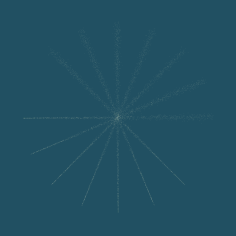

In [25]:
image_size = 100
# page setup
d = document(image_size, image_size, 'mm')
page = d.addpage()
page.place(background.rectangle(0,0,image_size,image_size))


nodes = np.array([
    [10, 50,0], 
    [90, 50,100]
])

rotation_point = np.array([50,50,0])
for i in range (7):
    theta = np.pi/8
    
    # page.place(netstyle.circle(*dither_line.p1[:2], 1))
    # page.place(netstyle.circle(*dither_line.p2[:2], 1))
    # page.place(debug.line(*dither_line.p1,*dither_line.p2))
    samples = add_z_jitter(sample_line(*nodes, 1000) ,0.004)

    for p in samples:
        page.place(sandstyle.circle(*p[:2], 0.1))
    nodes = rotate_xy(nodes, rotation_point, theta)
# Display image
Image((page.image(kind='rgba', ppi=60).png())) 

### Polygon test

#### Examination of rendering time for sampled polyhedra

In [8]:
%%time
image_size = 100
# page setup
d = document(image_size, image_size, 'mm')
page = d.addpage()
page.place(background.rectangle(0,0,image_size,image_size))
o = SampleOctahedron(np.array([50,50,40]),40)

o.rotate([50,50,40], [1,1,1], np.pi*2/16)





NameError: name 'SampleLine' is not defined

In [41]:
%%time
im = page.image(kind='rgba', ppi=60)
for p in samples.astype(int):
    im.put(p[0],p[1],(sand.r,sand.g,sand.b,sand.a))

CPU times: user 506 ms, sys: 1.84 ms, total: 508 ms
Wall time: 508 ms


In [42]:
red.r

255

CPU times: user 1.5 ms, sys: 377 µs, total: 1.88 ms
Wall time: 1.44 ms


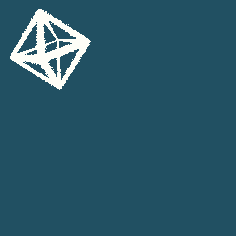

In [43]:
%%time
Image((im.png())) 

In [44]:
%%time
# linear with number of samples
samples = o.sample(1000,0.01)

CPU times: user 2.46 ms, sys: 865 µs, total: 3.32 ms
Wall time: 2.46 ms


In [45]:
samples

array([[49.15455415, 80.53445374, 31.73926986],
       [31.30299528, 70.24250098, 30.96604167],
       [42.92534175, 76.46288539, 31.40949082],
       ...,
       [21.20210252, 58.97697989, 44.34651181],
       [37.80387662, 56.96796612, 70.56251809],
       [13.77909831, 56.47841447, 34.58586033]])

In [46]:
%%time
# slightly more than linear with number of samples
for p in samples:
    page.place(sandstyle.circle(*p[:2], 0.1)) 
# Display image

CPU times: user 51.4 ms, sys: 1.27 ms, total: 52.7 ms
Wall time: 52.1 ms


CPU times: user 1.39 s, sys: 2.32 ms, total: 1.39 s
Wall time: 1.39 s


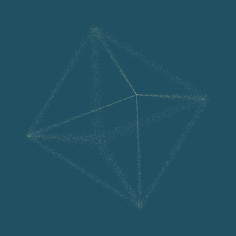

In [47]:
%%time
# linear with number of samples
Image((page.image(kind='rgba', ppi=60).png())) 

#### Dask delayed multiprocessing rendering of rotating image

In [27]:
@dask.delayed
def sample_octohedron(i):
    image_size = 100
    # page setup
    d = document(image_size, image_size, 'mm')
    page = d.addpage()
    page.place(background.rectangle(0,0,image_size,image_size))
    o = SampleOctahedron(np.array([50,50,40]),40)

    o.rotate([50,50,40], [1,1,1], np.pi*2/200*i)
    samples = o.sample(1000,0.03)

    for p in samples:
        page.place(sandstyle.circle(*p[:2], 0.1)) 
    # Display image
    page.image(kind='rgba', ppi=60).png(f'outputs/{i:03d}.png')
    return i

samples = [sample_octohedron(i) for i in range(200)]


In [ ]:
%%time
dask.persist(*samples, scheduler='processes')

In [ ]:
%%time
dask.persist(*samples, scheduler='threads')

In [ ]:
%%time
dask.persist(*samples, scheduler='single-threaded')

### Random network